In [1]:
import torch
torch.set_grad_enabled(False) # REQUIRED

## 1. Generating the data

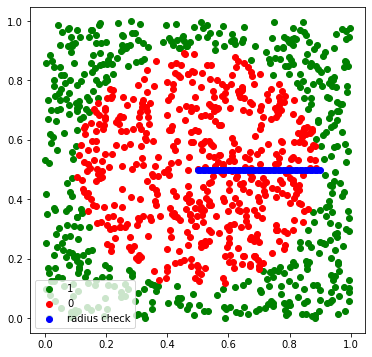

In [2]:
from utils import generate_dataset, show_dataset

X_train, y_train, X_test, y_test = generate_dataset(1000)
show_dataset(X_train, y_train[:,1])

### Testing linear regression

Text(0.5, 1.0, 'Error on b')

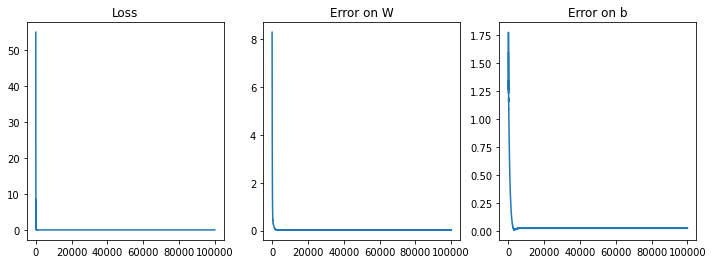

In [3]:
from module import Linear, ReLU, Tanh, LossMSE
import matplotlib.pyplot as plt



n_samples = 1000
input_dim = 20
output_dim = 2

x0 = torch.rand((n_samples, input_dim))


y = torch.rand((n_samples, output_dim))


W = torch.empty((output_dim, input_dim)).normal_(0, 1)
b = torch.empty(output_dim).normal_(0, 1)
y = torch.zeros((n_samples, output_dim))


for i in range(n_samples):
    x = x0[i]
    y[i] = torch.mv(W, x) + b
    
y += 0.05*torch.empty(y.shape).normal_(0, 1)
    
ll = Linear(input_dim, output_dim)
LS = LossMSE()


losses, d_w, d_b = [], [], []


nb_epochs = 10000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    ll.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        x2 = ll.forward(input_)
        
        loss = LS.forward(x2, target)

        grad_output = LS.backward()
        grad_input = ll.backward(grad_output)
        

        ll.W -= lr*ll.grad_W
        ll.b -= lr*ll.grad_b
        losses.append(loss.item())
        d_w.append(torch.norm(W-ll.W))
        d_b.append(torch.norm(b-ll.b.squeeze()))
    
f, ax = plt.subplots(1, 3, figsize = (12, 4))

ax[0].plot(losses)
ax[0].set_title('Loss')
ax[1].plot(d_w)
ax[1].set_title('Error on W')
ax[2].plot(d_b)
ax[2].set_title('Error on b')

In [4]:
W - ll.W

tensor([[-2.4282e-03, -3.3222e-03,  4.7005e-03, -3.5750e-03,  4.0809e-03,
          1.1890e-03, -4.4399e-04,  9.1444e-03, -6.8193e-03,  9.0811e-04,
         -1.0945e-02,  4.3319e-03,  7.7304e-03, -4.1486e-03,  2.1439e-03,
         -4.4826e-03,  3.6580e-03,  1.4344e-03,  1.7921e-03,  7.0037e-03],
        [-1.8923e-03,  1.3884e-03, -6.1884e-03, -2.8795e-03, -2.2107e-03,
         -1.3116e-02, -2.4494e-03, -7.1784e-03, -5.2226e-03,  3.7441e-03,
         -9.7606e-03,  5.1636e-03, -3.5700e-03,  2.0856e-03, -5.2518e-04,
         -1.0163e-05, -2.8147e-03, -3.1600e-03, -6.5166e-04,  5.4103e-03]])

In [5]:
b - ll.b

tensor([-0.0050,  0.0216])

In [6]:
d_w[-1], d_b[-1]

(tensor(0.0320), tensor(0.0222))

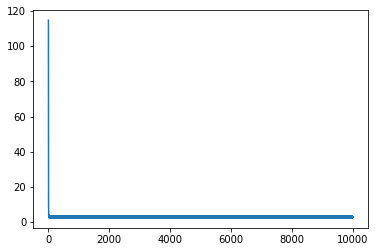

In [7]:
LS = LossMSE()

hidden_dim = 5
L1 = Linear(input_dim, hidden_dim)
R = ReLU()
L2 = Linear(hidden_dim, output_dim)

losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    L1.zero_grad()
    L2.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        x1 = L1.forward(input_)
        s1 = R.forward(x1)
        x2 = L2.forward(s1)
        loss = LS.forward(x2, target)
        # backward pass
        grad_x2 = LS.backward()
        grad_s1 = L2.backward(grad_x2)
        grad_x1 = R.backward(grad_s1)
        grad_input = L1.backward(grad_x1)
        

        L1.W -= lr*L1.grad_W
        L1.b -= lr*L1.grad_b
        
        L2.W -= lr*L2.grad_W
        L2.b -= lr*L2.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


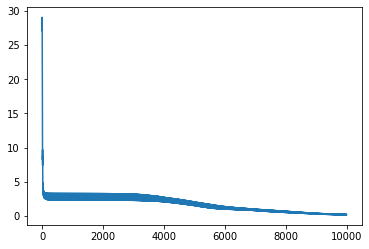

In [8]:
from module import Sequential 


hidden_1, hidden_2 = 6, 3
model = Sequential(Linear(input_dim, hidden_1), 
                   Tanh(),
                   Linear(hidden_1, hidden_2), 
                   Tanh(),
                   Linear(hidden_2, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    model.zero_grad()
    
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


### Testing on MNIST

In [9]:
from dlc_practical_prologue import load_data

train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [10]:
train_input.shape, train_target.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

Epoch 1: loss = 47.022, accuracy = 10.4% (train)/9.0% (test))
Epoch 51: loss = 1.546, accuracy = 26.8% (train)/14.7% (test))
Epoch 101: loss = 1.225, accuracy = 33.1% (train)/19.6% (test))
Epoch 151: loss = 1.068, accuracy = 34.9% (train)/21.1% (test))
Epoch 201: loss = 0.915, accuracy = 37.1% (train)/21.4% (test))
Epoch 251: loss = 0.895, accuracy = 39.0% (train)/22.2% (test))
Epoch 301: loss = 0.886, accuracy = 40.1% (train)/22.9% (test))
Epoch 351: loss = 0.878, accuracy = 41.6% (train)/23.8% (test))
Epoch 401: loss = 0.870, accuracy = 42.6% (train)/24.4% (test))
Epoch 451: loss = 0.865, accuracy = 44.1% (train)/25.1% (test))
Epoch 501: loss = 0.862, accuracy = 44.9% (train)/25.6% (test))
Epoch 551: loss = 0.859, accuracy = 46.2% (train)/25.2% (test))
Epoch 601: loss = 0.857, accuracy = 47.0% (train)/25.6% (test))
Epoch 651: loss = 0.856, accuracy = 47.6% (train)/26.3% (test))
Epoch 701: loss = 0.857, accuracy = 47.5% (train)/26.4% (test))
Epoch 751: loss = 0.855, accuracy = 48.7% (

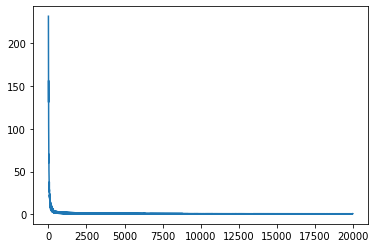

In [19]:
input_dim, h1, h2, h3, output_dim = 28**2, 100, 50, 20, 10

model = Sequential(Linear(input_dim, h1), 
                   Tanh(),
                   Linear(h1, h2), 
                   Tanh(),
                   Linear(h2, h3),
                   Tanh(),
                   Linear(h3, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 50
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    
    model.zero_grad()
    
    for i in range(0, train_input.size(0), mini_batch_size):
        input_ = train_input.narrow(0, i, mini_batch_size)
        target = train_target.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
        
    if epoch %50 == 1:
        prediction_train = model.forward(train_input).argmax(axis = 1)
        target_train = train_target.argmax(axis = 1)
        accuracy_train = (prediction_train == target_train).sum()/len(target_train)
        prediction_test = model.forward(test_input).argmax(axis = 1)
        target_test = test_target.argmax(axis = 1)
        accuracy_test = (prediction_test == target_test).sum()/len(target_test)
        print('Epoch {:d}: loss = {:.3f}, accuracy = {:.1f}% (train)/{:.1f}% (test))'.format(epoch, loss.item(),
                                                                                             accuracy_train*100, 
                                                                                             accuracy_test*100))
    
plt.plot(losses)